In [2]:
# TESTING TO APPLY PERTURBATION ONTO ORIGINAL IMAGE
# Foolbox, Mobilenetv2, PGD, Epsilon 0.1

In [3]:
import tensorflow as tf
import foolbox as fb

import eagerpy as ep
import numpy as np
import matplotlib.pyplot as plt
import pickle
from urllib.request import urlopen

import glob
from PIL import Image
import os

In [4]:
#variables
imagenet_key_value_pairs = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

In [5]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

In [6]:
# decode predictions number to label
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [7]:
# find label idx of prediction
def find_label_id(label):
    for key, value in imagenet_key_value_pairs.items():
        if label in value:
            return key

In [8]:
# Keras Applications are canned architectures with pre-trained weights.
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet')
preprocessing = dict()
bounds = (-1, 1)

# tensorflow model into foolbox model
fmodel = fb.TensorFlowModel(pretrained_model, bounds=bounds, preprocessing=preprocessing)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Model accuracy on sample images: 1.0


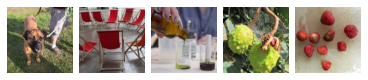

In [9]:
# optionally transform the bounds of the input space of our model
fmodel = fmodel.transform_bounds((0, 1))

# sample images
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=5)

# check accuracy on sample images and plot them
accuracy = fb.utils.accuracy(fmodel, images, labels)
print('Model accuracy on sample images:', accuracy)
# print(labels)
fb.plot.images(images)
plt.show()

640
426


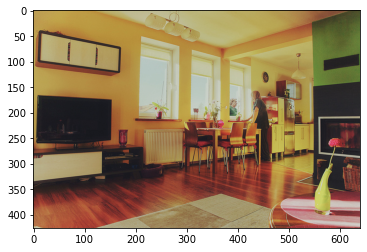

598 = home theater


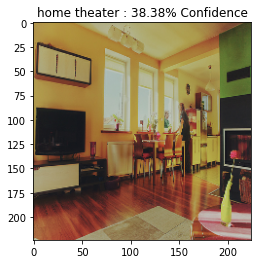

In [10]:
# load custom images and predict and view results

image_name = 'example_image.jpg'
image = Image.open(image_name)
width, height = image.size
print(width)
print(height)

im = tf.keras.preprocessing.image.array_to_img(image)
im = np.expand_dims(im, axis=0)
plt.imshow(im[0] / 255)
plt.show()

image_copy = im.copy()


image_probabilities = []
own_images = []

image_ids = []
original_name = []

image_raw = tf.io.read_file(image_name)
image = tf.image.decode_image(image_raw)
image = preprocess(image)
own_images.append(image)
image_probs = pretrained_model.predict(image)
image_probabilities.append(image_probs)
original_name.append(image_name)
    
for x, y in zip(own_images, image_probabilities):
    plt.figure()
    plt.imshow(x[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]?
    _, image_class, class_confidence = get_imagenet_label(y)
    image_class = image_class.replace("_", " ")
    print(str(find_label_id(image_class)) + ' = ' + image_class) # if none error incurs later
    image_ids.append(find_label_id(image_class))
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.show()


Min values in image-array: -0.9513864 Max values in image-array: 0.7846571
(224, 224, 3)
Min values in image-array: 0.024306804 Max values in image-array: 0.89232856


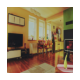

In [11]:
# Prints values of pixels
print('Min values in image-array: ' + str(np.amin(own_images)) + ' Max values in image-array: ' + str(np.amax(own_images)))

#Convert own images and corresponding labels for foolbox approved type
own_images_tf = []
own_labels_tf = tf.convert_to_tensor(image_ids, dtype=tf.int32)

for x in own_images.copy():
    a = tf.squeeze(x)
    print(a.shape)
    a = (a + 1.0)/2 # shift from [-1,1] to [0,1] with 0.5 mean
    own_images_tf.append(a)

own_images_tf = tf.convert_to_tensor(own_images_tf, dtype=tf.float32)

# Prints values of pixels after processing
print('Min values in image-array: ' + str(np.amin(own_images_tf)) + ' Max values in image-array: ' + str(np.amax(own_images_tf)))

# Testing that conversion works
fb.plot.images(own_images_tf)
#accuracy = fb.utils.accuracy(fmodel, own_images_tf, own_labels_tf)
#print('Model accuracy on own images:', accuracy)

LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
TensorFlowTensor(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>)


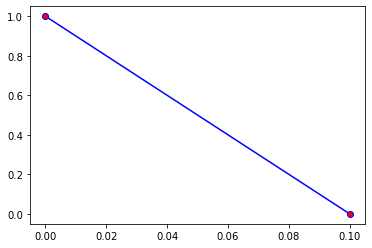

In [20]:
# instantiate the corresponding attack class
def attack_type(attack):
    if attack == 'LinfPGD':
        return fb.attacks.LinfProjectedGradientDescentAttack()
    elif attack == 'FGSM':
        return fb.attacks.LinfFastGradientAttack()
    elif attack == 'CW_L2':
        return fb.attacks.L2CarliniWagnerAttack()
    elif attack == 'DeepFool':
        return fb.attacks.L2DeepFoolAttack()
    else:
        print('Select valid attack')

# steps = 10
#epsilons = np.linspace(0.0, 0.10, num=steps)
epsilons = [0.0, 0.1]

attacks = ['LinfPGD',
          'FGSM',
          'CW_L2',
          'DeepFool']

attack = attack_type(attacks[1])
print(attack)

# use eagerpy tensors sample images
#images = ep.astensor(images)
#labels = ep.astensor(labels)

# use eagerpy tensors own images
images = ep.astensor(own_images_tf)
labels = ep.astensor(own_labels_tf)


# all are tensors
# raw = The raw adversarial examples. --> depends on attack
# clipped = The clipped adversarial examples --> guaranteed to not be perturbed more than epsilon.
# is_adv = boolean for each sample image. True if misclassified and within the epsilon balls around the clean sample.
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

print(is_adv.float32().mean(axis=-1))
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)

# show accuracy vs epsilons
plt.plot(epsilons, robust_accuracy.numpy(), color='blue', linestyle='solid', marker='o', markerfacecolor='red')
plt.show()

Epsilon value of adversary: 0.0


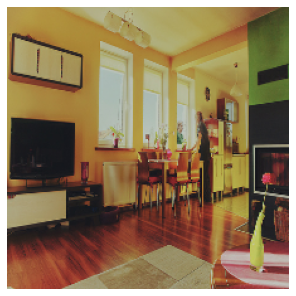

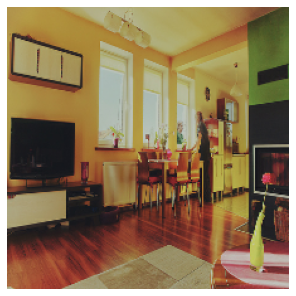

Epsilon value of adversary: 0.1


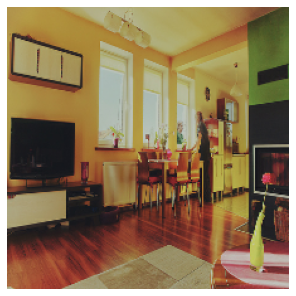

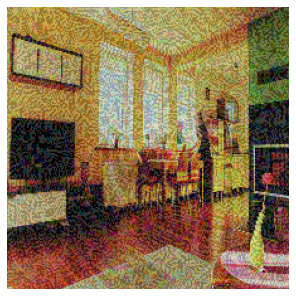

In [21]:
# show adversary
for adversary, epsilon in zip(clipped, epsilons):
    print('Epsilon value of adversary:', str(epsilon))
    #fb.plot.images(adversary - images, bounds=(-0.1, 0.1), scale=4.)
    fb.plot.images(images, bounds=(0, 1), scale=4.)
    perturbation = adversary - images
    fb.plot.images(images + perturbation, bounds=(0, 1), scale=4.)
    plt.show()

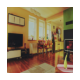

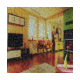

In [24]:
# show adversarial images using fb.plot
for adversary in clipped:
    fb.plot.images(adversary)
    plt.show()

In [25]:
# TESTING PERTURBATION OVER ORIGINAL IMAGE

for adversary, epsilon in zip(clipped, epsilons):
    #cut perturbation from image
    perturbation = adversary - images
    #perturbation to numpy array
    x = perturbation.numpy()
    # squeeze 1 dimension so that we have (height, width, channels)
    x = np.squeeze(x)
    print('Perturbation image shape', x.shape)
    # resize the perturbation to same size than original image
    x = np.resize(x, (height, width, 3))
    
    # Change the pixel values of perturbation. This affects the brightness and color of perturbation.
    print('Original min and max values of pixels of perturbation image')
    print(np.amin(x))
    print(np.amax(x))
    print()
    x = ((x + 1)/2) * 255
    print('Min and max values of pixels after change in perturbation image')
    print(np.amin(x))
    print(np.amax(x))
    print('-------------------------------------')
    
    # Make numpy array of original image
    org = np.squeeze(image_copy)
    print('Min and max values of pixels in original image')
    print(np.amin(org))
    print(np.amax(org))
    print('Original image shape', org.shape)
    print('-------------------------------------')
    
    # apply perturbation into the image and visualize
    #expanded_adversarial_image = org
    expanded_adversarial_image = (org + x) / 2
    print('Min and Max values of original image with perturbation')
    print(np.amin(expanded_adversarial_image))
    print(np.amax(expanded_adversarial_image))
    im1 = Image.fromarray((expanded_adversarial_image).astype(np.uint8))
    im1.show()
    im1.save('original_plus_perturbation/testi_epsilon_{}.jpg'.format(epsilon))

Perturbation image shape (224, 224, 3)
Original min and max values of pixels of perturbation image
0.0
0.0

Min and max values of pixels after change in perturbation image
127.5
127.5
-------------------------------------
Min and max values of pixels in original image
0
255
Original image shape (426, 640, 3)
-------------------------------------
Min and Max values of original image with perturbation
63.75
191.25
Perturbation image shape (224, 224, 3)
Original min and max values of pixels of perturbation image
-0.100000024
0.100000024

Min and max values of pixels after change in perturbation image
114.75
140.25
-------------------------------------
Min and max values of pixels in original image
0
255
Original image shape (426, 640, 3)
-------------------------------------
Min and Max values of original image with perturbation
57.375
193.625


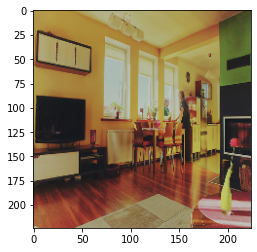

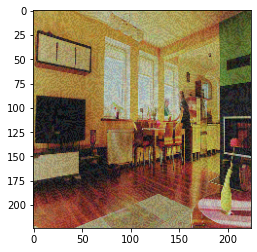

In [19]:
# Creates figure object containing image, class and class confidence
class MyFigure:
    def __init__(self, image , image_class, class_confidence):
        self.image = image
        self.image_class = image_class
        self.class_confidence = class_confidence

# Save images
def save_images(images, epsilon):
    for x in range(0, len(images)):
        _, image_class, class_confidence = get_imagenet_label(image_probs)
        name = original_name[x]
        im = Image.fromarray((images[x].image * 255).astype(np.uint8))
        newsize = (width,height)
        im1 = im.resize(newsize)
        im1.show()
        im1.save('ae_reshaped/image_with_epsilon_{}.jpg'.format(epsilon))
        
# Shows figures        
def show_figures(images, epsilon):
    fig, ax = plt.subplots(1, len(images))
    for x in range(0, len(images)):
        ax.imshow(images[x].image) # * 0.5 + 0.2
    plt.show()

# perturbed_step contains all images on step eg 2 for epsilon 0.01
for perturbed_step, epsilon in zip(clipped, epsilons):
    list_of_figures = []
    
    for x in perturbed_step:
        x = x.numpy()
        image = np.expand_dims(x, axis=0)
        image_probs = pretrained_model.predict(image)
        _, image_class, class_confidence = get_imagenet_label(image_probs)       
        
        #create fig object
        a = MyFigure(x, image_class, class_confidence)
        list_of_figures.append(a)
        
    show_figures(list_of_figures, epsilon)
    save_images(list_of_figures, epsilon)